# Final Project - Training Data

This Notebook loads and displays some examples from the training dataset.

The training dataset contains a total of 8443 samples. All groups have been given the same training dataset and the final report will be graded based on the performance on this training data.

* You should expect the test dataset to have the same format as the training data: $270,000\times M$ ```numpy``` array, where $M$ is the number of test samples.
* This means that *any* pre-processing applied in the training data should also be applied in the test data.

---

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.preprocessing.image import Iterator
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Flatten, Convolution2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from utils import RotNetDataGenerator, crop_largest_rectangle, angle_error, rotate, binarize_images, display_examples
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import TensorBoard
import numpy as np
from skimage.transform import rotate, resize
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

In [2]:
data_train = np.load('data_train.npy')
labels_train = np.load('labels_train.npy')

X_train, X_test, y_train, y_test = train_test_split(data_train.T, labels_train, test_size=0.2, random_state=42)

In [3]:
X_train = X_train.reshape(-1,300,300,3)
print(X_train.shape)

(6754, 300, 300, 3)


In [4]:
X_test = X_test.reshape(-1,300,300,3)
print(X_test.shape)

(1689, 300, 300, 3)


In [5]:
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

In [6]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(6754, 300, 300, 3) (6754, 9) (1689, 300, 300, 3) (1689, 9)


In [7]:
# number of convolutional filters to use
nb_filters = 64
# size of pooling area for max pooling
pool_size = (2, 2)
# convolution kernel size
kernel_size = (3, 3)

nb_train_samples = X_train.shape[0]
img_rows, img_cols, img_channels = X_train.shape[1:]
input_shape = (img_rows, img_cols, img_channels)
nb_test_samples = X_test.shape[0]
nb_classes = 360

# model definition
input = Input(shape=input_shape)  # Updated the input shape
x = Convolution2D(nb_filters, kernel_size[0], kernel_size[1],
                  activation='relu')(input)
x = Convolution2D(nb_filters, kernel_size[0], kernel_size[1],
                  activation='relu')(x)
x = MaxPooling2D(pool_size=pool_size)(x)  # Simplified the pool_size usage
x = Dropout(0.25)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)  # Adjusted dropout, can be tuned
x = Dense(nb_classes, activation='softmax')(x)

model = Model(inputs=input, outputs=x)

2023-11-21 15:34:33.175843: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-21 15:34:35.044290: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78911 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:47:00.0, compute capability: 8.0
2023-11-21 15:34:35.047324: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 78911 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:4e:00.0, compute capability: 8.0


In [8]:
# model compilation
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=[angle_error, 'accuracy'])

In [9]:
# training parameters
batch_size = 128
nb_epoch = 50
output_filename = "rotnet"

# callbacks
checkpointer = ModelCheckpoint(
    filepath=output_filename,
    save_best_only=True
)
early_stopping = EarlyStopping(patience=2)
tensorboard = TensorBoard()

# training loop
history = model.fit(
    RotNetDataGenerator(X_train, preprocess_func=binarize_images),
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=nb_epoch,
    validation_data=RotNetDataGenerator(X_test, preprocess_func=binarize_images),
    validation_steps=nb_test_samples // batch_size,
    verbose=1,
    callbacks=[checkpointer, early_stopping, tensorboard]
)

Epoch 1/50


2023-11-21 15:34:39.370820: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201
2023-11-21 15:34:42.154945: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


52/52 [==============================] - ETA: 0s - loss: 1.5941 - angle_error: 60.5305 - accuracy: 0.4585

2023-11-21 15:34:52.175022: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: rotnet/assets
52/52 [==============================] - 15s 186ms/step - loss: 1.5941 - angle_error: 60.5305 - accuracy: 0.4585 - val_loss: 0.1263 - val_angle_error: 2.0553 - val_accuracy: 0.9784
Epoch 2/50
52/52 [==============================] - 10s 184ms/step - loss: 0.0855 - angle_error: 1.8389 - accuracy: 0.9803 - val_loss: 0.0235 - val_angle_error: 0.9736 - val_accuracy: 0.9904
Epoch 3/50
52/52 [==============================] - 9s 174ms/step - loss: 0.0373 - angle_error: 0.9195 - accuracy: 0.9904 - val_loss: 0.0308 - val_angle_error: 0.8654 - val_accuracy: 0.9916
Epoch 4/50
52/52 [==============================] - 9s 183ms/step - loss: 0.0349 - angle_error: 0.7572 - accuracy: 0.9915 - val_loss: 0.0140 - val_angle_error: 0.5409 - val_accuracy: 0.9940
Epoch 5/50
52/52 [==============================] - 9s 174ms/step - loss: 0.0340 - angle_error: 1.0547 - accuracy: 0.9894 - val_loss: 0.0240 - val_angle_error: 0.8654 - val_accuracy: 0.9904
Epoch 6/5

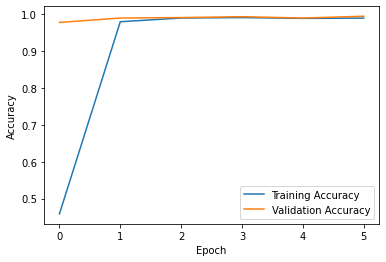

In [10]:
# Access accuracy from history
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Plot accuracy over epochs
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [11]:
print(training_accuracy[-1])
print(validation_accuracy[-1])

0.9900841116905212
0.995192289352417


True angle:  90
Predicted angle:  270


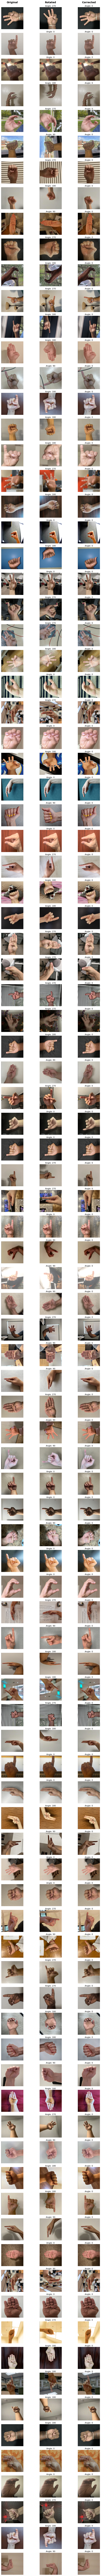

In [22]:
# randomly rotate an image
original_img = X_test[0]
rotation_angles = [0, 90, 180, 270]
true_angle = np.random.choice(rotation_angles)
rotated_img = rotate(original_img, true_angle)
print('True angle: ', true_angle)

rotated_img_with_batch = rotated_img[np.newaxis, :, :, :]
rotated_img_with_batch = rotated_img_with_batch.astype('float32')
rotated_img_bin = binarize_images(rotated_img_with_batch)

#output = model.predict(rotated_img_bin)
predicted_angle = np.argmax(model.predict(rotated_img_bin))
print('Predicted angle: ', predicted_angle)

num_images = 100

# Display examples
display_examples(
    model, 
    X_test,
    num_images=num_images,
    preprocess_func=binarize_images,
)